# Boundary Conditions for multi-phase flows

**BoundaryConditions:**<br />
documentation: http://proteustoolkit.org/api/proteus.BoundaryConditions.html <br />
(documentation does not appear because the module is cythonised, see source below for the functions available and general documentation)<br />
source: https://github.com/erdc/proteus/blob/master/proteus/SpatialTools.py<br />

**mprans.BoundaryConditions** (multi-phase flow):<br />
documentation: http://proteustoolkit.org/api/proteus.mprans.SpatialTools.html<br />
(documentation does not appear because the module is cythonised, see source below for the functions available and general documentation)<br />
source: https://github.com/erdc/proteus/blob/master/proteus/mprans/SpatialTools.py<br />

## Boundary Conditions on segments (2D) and facets (3D)

General imports

In [33]:
%matplotlib notebook
# general imports
import numpy as np
from proteus import Domain
from proteus.mprans import SpatialTools as st  # import from mprans
from nbtools import plot_domain # only for this notebook

Firstly, the domain geometry is defined. If a custom shape is to be defined, the `boundaryTags` variable (dictionary) as shown below is what will be used to access and set boundary conditions.

<IPython.core.display.Javascript object>


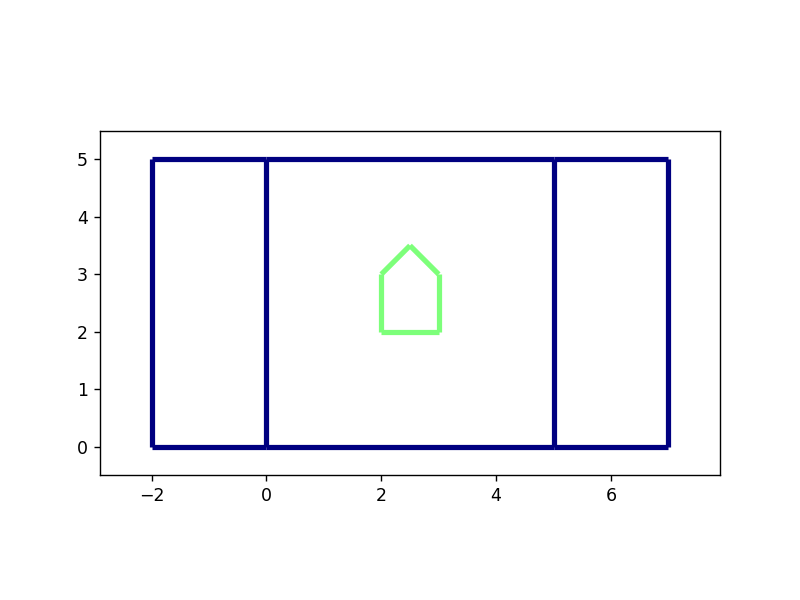

In [20]:
# domain
domain = Domain.PlanarStraightLineGraphDomain()

# various geometries
# tank (predifined in SpatialTools)
my_tank = st.Tank2D(domain, dim=[5., 5.])
my_tank.setSponge(x_n=2., x_p=2.)  # x_n for x-, x_p for x+
# custom (can be any geometry)
# you can change/add tags and/or geometry
bt = {'tag1': 1, 'tag2': 2}
# flags of bt must be integers starting from 1 and must form a straight with +1 increments
my_custom = st.CustomShape(domain,
                           boundaryTags=bt,
                           vertices=[[0., 0.], [1., 0.], [1., 1.], [0.5, 1.5], [0., 1.]],
                           vertexFlags=[bt['tag1'], bt['tag1'], bt['tag2'], bt['tag2'], bt['tag2']],
                           segments=[[0, 1], [1, 2], [2, 3], [3, 4], [4, 0]],
                           segmentFlags=[bt['tag1'], bt['tag2'], bt['tag2'], bt['tag2'], bt['tag1']],
                           regions=[[0.5, 0.5]],
                           regionFlags=[1])
# move shape
my_custom.translate([2., 2.])
# assemble domain
st.assembleDomain(domain)
# plot domain
plot_domain(domain)

### Accessing Boundary Conditions

When the shape is created, boundary condition class instances (from proteus.mprans.BoundaryConditions) are stored in a dictionary. There are as many boundary conditions in the dictionary as there are boundary tags.

In [21]:
print('tank BC: {BCs}'.format(BCs=my_tank.BC.keys()))
print('custom BC: {BCs}'.format(BCs=my_custom.BC.keys()))

tank BC: ['sponge', 'x+', 'y+', 'y-', 'x-']
custom BC: ['tag1', 'tag2']


The boundary conditions can simply be accessed as follows:

```
rightBC = tank.BC['x+']
```

In [22]:
my_tank.BC['x+']

### Modifying Boundary Conditions

Boundary conditions are always functions of space (`x`) and time (`t`) so an individual boundary condition component must be set as a python function taking the arguments `(x, t)` (with `x` an array of length 3, and `t` a scalar value).

Individual components of the boundary conditions be accessed through the dictionary (`shape.BC['tag']`) of a shape by providing the intended tag. It is also possible to iterate through the list of boundary conditions (`shape.BC_list`) to rapidly set boundary conditions on all boundary of the shape at once.

The following table shows what variables are accessible:

| model         | variable        | BC             | dirichlet | advective | diffusive | format   |
|---------------|-----------------|----------------|-----------|-----------|-----------|----------|
| Navier-Stokes | fluid pressure  | p              | yes       | yes       | no        | f(x,t)   |
|               | fluid velocity  | u, v, w        | yes       | yes       | yes       | f(x,t)   |
| VOF           | volume-of-fluid | vof            | yes       | yes       | no        | f(x,t)   |
| moveMesh      | displacement    | hx, hy, hz     | yes       | no        | no        | f(x,t)   |
|               | stress          | (u,v,w)_stress | no        | no        | no        | constant |
| Turbulence    | kappa           | k              | yes       | yes       | yes       | f(x,t)   |
|               | epsilon/omega   | dissipation    | yes       | yes       | yes       | f(x,t)   |

The variable `uOfXT` is used for the function of the boundary condition, and can be accessed as follows:

`shape.BC['tag'].u_dirichlet.uOfXT = lambda x, t: 0.`

In [23]:
leftBC = my_tank.BC['x-']  # access boundary condition class

def constantBC(x, t):
    return 0.

def linearBC(x, t):
    return 0.14*t

leftBC.u_dirichlet.uOfXT = linearBC
leftBC.v_dirichlet.uOfXT = constantBC
leftBC.w_dirichlet.uOfXT = constantBC

leftBC.p_advective.uOfXT = constantBC
leftBC.vof_advective.uOfXT = constantBC

x = np.zeros(3)  # x must be a numpy array of length 3
print('u_dirichlet at time 0.: {BC}'.format(BC=leftBC.u_dirichlet.uOfXT(x, 0.)))
print('u_dirichlet at time 2.5: {BC}'.format(BC=leftBC.u_dirichlet.uOfXT(x, 2.5)))

u_dirichlet at time 0.: 0.0
u_dirichlet at time 2.5: 0.35


Predefined boundary conditions are a way to easily set all boundary condition components to shape boundaries. These predefined boundary conditions include:
 - `setNoSlip()`: no-slip boundary conditions
 - `setFreeSlip()`: free-slip boundary condition
 - `setAtmosphere()`: lets air and water out of the tank. When water comes out, it does not come back.
 - `setUnsteadyTwoPhaseVelocityInlet()`: for wave generation. Should be used along with a relaxation zone.
 - `setNonMaterial()`: for boundaries that are not physical, such as a boundary in the tank for a relaxation zone.
 - `setFixedNodes()`: fixes nodes in space and time
 


In [24]:
# through dictionary
my_custom.BC['tag1'].setNoSlip()
my_custom.BC['tag2'].setFreeSlip()

# through list
for BC in my_tank.BC_list:
    BC.setNoSlip()

# through variable name
my_tank.BC['y+'].setAtmosphere()
my_tank.BC['sponge'].setNonMaterial()

## Boundary conditions in regions

The regional boundary conditions available in proteus are relaxation zones (absorption/generation zones) and porous zones, where the arguments are:
- **epsFact_solid**: must be half of the region length
- **center**: coordinates of the center of the region
- **orientation**: orientation vector of the absorption zone, going from the external boundary to the boundary of the tank
- **smoothing**: smoothing area for VOF model (usually $3\times h_e$)
- **dragAlpha, dragBeta, porosity**: options for porous media. dragAlpha should be $\frac{5\omega}{\nu_0}$ for relaxation zones (with $\omega$ the angular frequency of the wave and $\nu_0$ the water viscosity)

### Relaxation Zones

Relaxation zones (wave absorption/generation) impose boundary conditions throughout a region using a blending function
$$
\begin{eqnarray}
\alpha = \frac{e^{d^{3.5}}-1}{e^1-1} \\
\end{eqnarray}
$$
where $d$ scales linearly from 0 (at the tank/relaxation zone boundary) to 1 (at the boundary), $u_n$ is the solution given by the model. This boundary condition is imposed as a source term in the Navier-Stokes equations using the porosity module of Proteus.

#### Absorption Zones

Absorption zones impose a dirichlet velocity of zero using the blending function defined above

In [25]:
# target wave period
period = 1.4
# corresponding dragAlpha
dragAlpha = 5*2*np.pi/period/(1.004e-6) 
# set absorption zone on region flagged 1
my_custom.setAbsorptionZones(flags=1, epsFact_solid=1., center=[1., 2.5], orientation=[1., 0.], dragAlpha=dragAlpha)

print(my_custom.auxiliaryVariables)

{'RelaxZones': {1: <mprans.BoundaryConditions.RelaxationZone object at 0x3c8e230>}}


The Tank2D/Tank3D class makes it easier to define, the following has the same effect as above:

In [26]:
# set absorption zone on right region ('x+')
my_tank.setAbsorptionZones(x_p=True, dragAlpha=dragAlpha)

print(my_tank.auxiliaryVariables)

{'RelaxZones': {3: <mprans.BoundaryConditions.RelaxationZone object at 0x3c8e700>}}


#### Generation Zones

In [27]:
from proteus import WaveTools as wt
# create a wave
my_waves = wt.MonochromaticWaves(period=0.8, waveHeight=0.03, mwl=0.6, depth=0.6,
                                 g=np.array([0, -9.81, 0.]), waveDir=[1., 0., 0.])
# element size around free surface (arbitrary here)
he = 0.1
# smoothing area around free surface
smoothing = 3*he
# set generation zone on the left region of the tank ('x-')
my_tank.setGenerationZones(x_n=True, waves=my_waves, wind_speed=np.array([0., 0.]), dragAlpha=dragAlpha, smoothing=smoothing)
# set boundary condition as well on the left wall ('x-')
my_tank.BC['x-'].setUnsteadyTwoPhaseVelocityInlet(wave=my_waves, wind_speed=np.array([0., 0.]), smoothing=smoothing)

print(my_tank.auxiliaryVariables['RelaxZones'])

{2: <mprans.BoundaryConditions.RelaxationZone object at 0x3ce5b10>, 3: <mprans.BoundaryConditions.RelaxationZone object at 0x3c8e700>}


### Porous Zones


In [28]:
my_custom.setPorousZones(1, porosity=0.5, dragAlpha=1/1e-6, dragBeta=0)

## Boundary Conditions access in _p.py files

### Segment/facet boundary conditions
In the ***_p.py** files, directly through their flags. For example, in twp_navier_stokes_p.py, the dirichlet boundary condition function of u is accessed through, for example: `domain.BCbyFlag[flag].u_dirichlet.uOfXT`.
For example, BCs in Navier-Stokes in `twp_navier_stokes_p.py` are defined as follows:

```
dirichletConditions = {0: lambda x, flag: domain.BCbyFlag[flag].p_dirichlet.uOfXT,
                       1: lambda x, flag: domain.BCbyFlag[flag].u_dirichlet.uOfXT,
                       2: lambda x, flag: domain.BCbyFlag[flag].v_dirichlet.uOfXT}
```

### Regional boundary conditions
In the ***_n.py** files, auxiliary variables are accessed at each time step when solving navier stokes equations

## Local vs Global access to BC

When the domain is assembled with `st.assembleDomain(domain)`, the assembled global flags in the `domain` are different from the local (shape) flags.

color code: 
- vertices: blue
- segments: green
- regions: red

In [29]:
tag = 'tag1'
ind_local = my_custom.BC_list.index(my_custom.BC[tag]) # get index of BC in shape (starts at 1)
ind_global = domain.bc.index(my_custom.BC[tag])
print("local index of BC {tag}: {ind}".format(tag=tag, ind=ind_local))
print("global index of BC {tag}: {ind}".format(tag=tag, ind=ind_global))

local index of BC tag1: 0
global index of BC tag1: 6


### Local

<IPython.core.display.Javascript object>


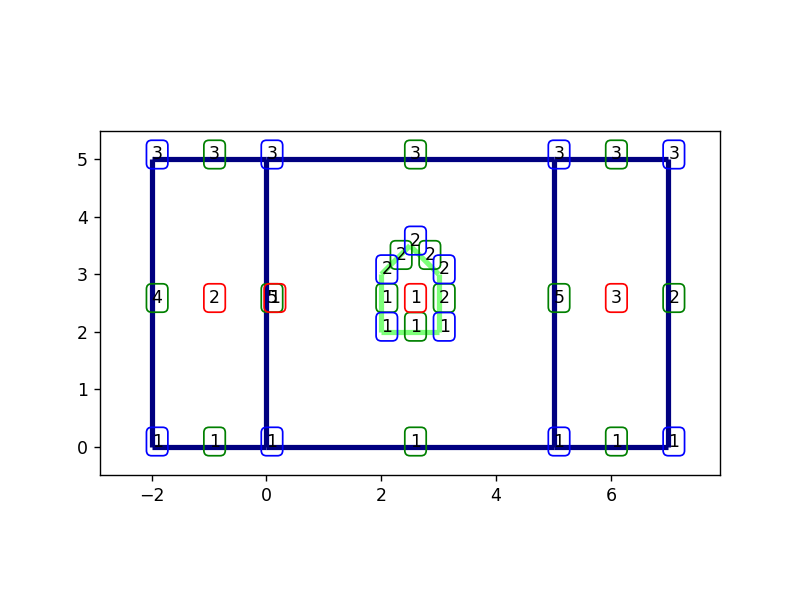

In [30]:
plot_domain(domain, vertexFlags='local', regionFlags='local', segmentFlags='local')

### Global

<IPython.core.display.Javascript object>


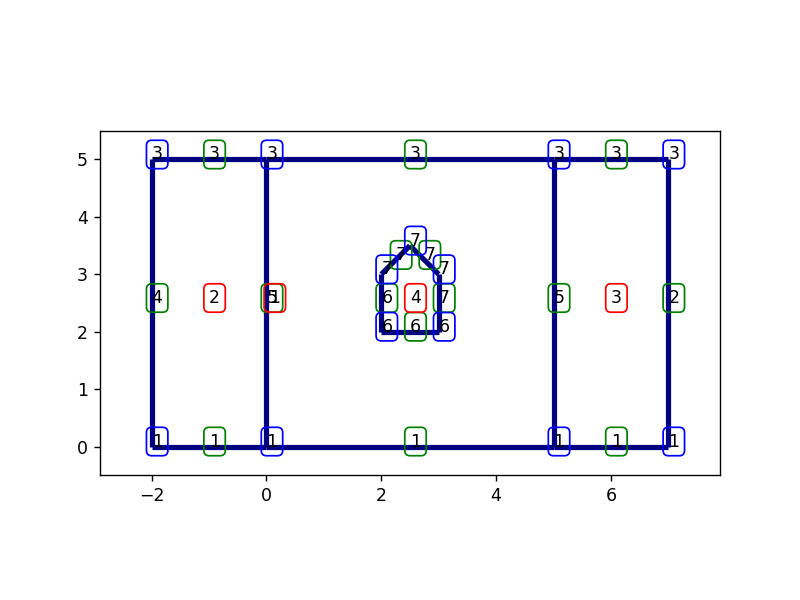

In [31]:
plot_domain(domain, vertexFlags='global', regionFlags='global', segmentFlags='global')

If necessary, the same BC calss instance can be accessed from the shape (locally) but also from the domain (globally) by adding the name of the shape to the tag as follows:

In [32]:
shape = my_custom
tag_local = 'tag1'

tag_global = shape.name+'_'+tag  # don't forget to add _ between the name and tag

print('Same BC: {ans}'.format(ans=(shape.BC[tag_local] == domain.BC[tag_global])))

Same BC: True
